<a href="https://colab.research.google.com/github/kaiquefreire05/tweets-classification-nlp/blob/main/tweets_classification_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de textos do Twitter

# Instalação e importação das bibliotecas

In [ ]:
!pip install spacy

In [ ]:
!python -m spacy download pt_core_news_sm

In [3]:
# Importando Spacy e verificando sua precisão

import spacy # biblioteca spaCy para processamento de linguagem natural (NLP)
spacy.__version__

'3.7.3'

In [4]:
# Importando o resto das bibliotecas

import pandas as pd # biblioteca Pandas para manipulação de dados
import seaborn as sns # biblioteca Seaborn para visualização estatística
import numpy as np # biblioteca NumPy para operações numéricas eficientes
import matplotlib.pyplot as plt # biblioteca Matplotlib para criação de gráficos
import string # biblioteca string para manipulação de strings
import random # biblioteca random para geração de números aleatórios
import en_core_web_sm # modelo "en_core_web_sm" do spaCy
import re # módulo 're' (expressões regulares) do Python
from spacy.lang.pt.stop_words import STOP_WORDS # importando a lista de palavras de parada
from spacy.training import Example # importa a classe Example do módulo spacy.training
from sklearn.metrics import accuracy_score # importa função de taxa de acurácia
from sklearn.metrics import confusion_matrix # import função da matriz de confusão
from sklearn.metrics import classification_report # importa função da tabela de classificação

# Carregamento das bases de dados

- Link Kaggle: https://www.kaggle.com/augustop/portuguese-tweets-for-sentiment-analysis#TweetsNeutralHash.csv

## Base de treinamento

- Negative: 0
- Positive: 1

In [5]:
# Fazendo o carregamento da base de dados e visualizando as 5 primeiras linhas

base_treinamento = pd.read_csv('/content/drive/MyDrive/datasets/Train50.csv', delimiter=';')
base_treinamento.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)


In [6]:
# Verificando o tamanho da base de dados

base_treinamento.shape

(50000, 5)

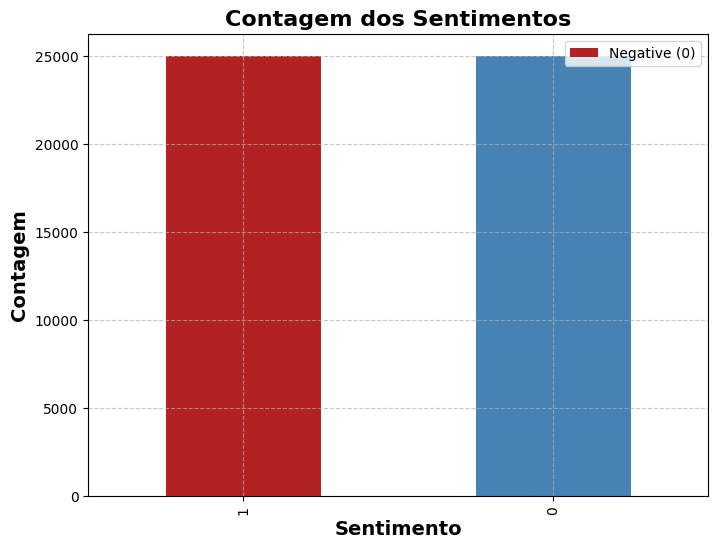

In [7]:
# Criando gráfico para fazer a visualização da contagem de sentimentos

contagem = base_treinamento['sentiment'].value_counts() # fazendo a contagem dos resultados

# cores personalizadas para os valores 0 e 1
colors = ['firebrick', 'steelblue']

# criando o gráfico de barras
fig, ax = plt.subplots(figsize=(8, 6))  # cefinindo o tamanho da figura
contagem.plot(kind='bar', color=colors, ax=ax)  # cores personalizadas

# adicionando título e rótulos dos eixos
plt.title('Contagem dos Sentimentos', fontsize=16, fontweight='bold')
plt.xlabel('Sentimento', fontsize=14, fontweight='bold')
plt.ylabel('Contagem', fontsize=14, fontweight='bold')

# adicionando legenda
plt.legend(['Negative (0)', 'Positive (1)'], loc='upper right')

# adicionando linhas de grade ao gráfico
plt.grid(True, linestyle='--', alpha=0.7)

# exibindo o gráfico
plt.show()

In [8]:
# Removendo colunas que não serão necessárias

base_treinamento.drop(['id', 'tweet_date', 'query_used'], axis= 1, inplace=True)
# axis= 1, remove a coluna
# inplace= True, modificia diretamente a base de dados

In [9]:
base_treinamento.head()

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o ...,1
1,"@behin_d_curtain Para mim, é precisamente o co...",1
2,Vou fazer um video hoje... estou pensando em f...,1
3,"aaaaaaaa amei tanto essas polaroids, nem sei e...",1
4,Valoriza o coração do menininho que vc tem. El...,1


In [10]:
# Verificando se existe campos nulos

base_treinamento.isnull().sum()

tweet_text    0
sentiment     0
dtype: int64

## Base de teste

In [11]:
# Fazendo o upload da base de dados e mostrando 5 primeiras linhas

base_teste = pd.read_csv('/content/drive/MyDrive/datasets/Test.csv', delimiter=';')
base_teste

,id,tweet_text,tweet_date,sentiment,query_used
0,1029536486021099522,@Gazo1a Nossa! Muito obrigada :),Wed Aug 15 01:13:20 +0000 2018,1,:)
1,1029536496368406528,@BerzGamer vai pa puta que te pariu :),Wed Aug 15 01:13:23 +0000 2018,1,:)
2,1029536531655131137,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,Wed Aug 15 01:13:31 +0000 2018,1,:)
3,1029536560117678081,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",Wed Aug 15 01:13:38 +0000 2018,1,:)
4,1029536605852377088,Estávamos em casa do Zé e eu estava a morrer d...,Wed Aug 15 01:13:49 +0000 2018,1,:)
...,...,...,...,...,...
4995,1030528364145201153,@ol_cdanilo parece livro de autoajuda :(,Fri Aug 17 18:54:42 +0000 2018,0,:(
4996,1030528418235015168,@tatazoquita aaaaa sinto muito :((,Fri Aug 17 18:54:55 +0000 2018,0,:(
4997,1030528446122930176,To começando a sentir dor de novo e meu irmão ...,Fri Aug 17 18:55:02 +0000 2018,0,:(
4998,1030528453752352769,@ichbintw parece que no dia que toma a vacina ...,Fri Aug 17 18:55:04 +0000 2018,0,:(


In [12]:
# Verificando o tamanho da base de dados de teste

base_teste.shape

(5000, 5)

In [13]:
# Dropando colunas que não vão ser usadas

base_teste.drop(['id', 'tweet_date', 'query_used'], axis= 1, inplace=True)
base_teste.head() # mostrando 5 primeiras linhas

,tweet_text,sentiment
0,@Gazo1a Nossa! Muito obrigada :),1
1,@BerzGamer vai pa puta que te pariu :),1
2,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,1
3,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",1
4,Estávamos em casa do Zé e eu estava a morrer d...,1


In [14]:
# Verificando a contagem de campos nulos

base_teste.isnull().sum()

tweet_text    0
sentiment     0
dtype: int64

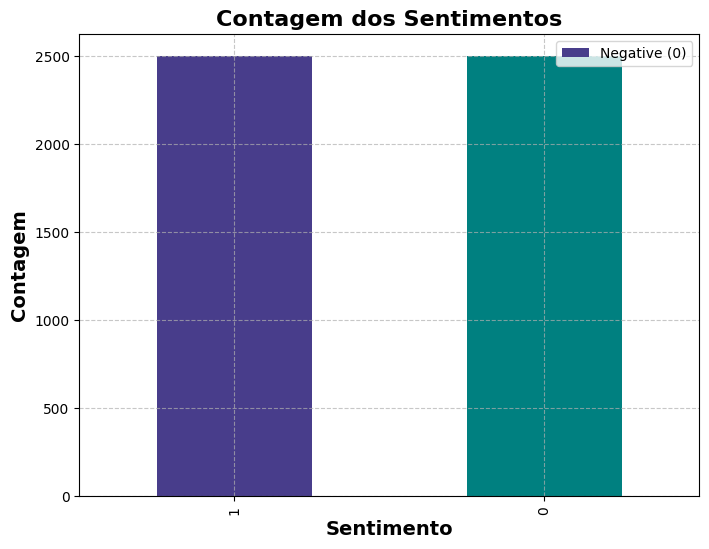

In [15]:
# Criando gráfico para fazer a visualização da contagem de sentimentos

contagem_teste = base_teste['sentiment'].value_counts() # fazendo a contagem dos resultados
colors = ['darkslateblue', 'teal'] # definindo cores das barras

# criando o gráfico de barras
fig, ax = plt.subplots(figsize=(8, 6))  # cefinindo o tamanho da figura
contagem_teste.plot(kind='bar', color=colors, ax=ax)  # cores personalizadas, estilo e variável contada

# adicionando título e rótulos dos eixos
plt.title('Contagem dos Sentimentos', fontsize=16, fontweight='bold')
plt.xlabel('Sentimento', fontsize=14, fontweight='bold')
plt.ylabel('Contagem', fontsize=14, fontweight='bold')

# adicionando legenda
plt.legend(['Negative (0)', 'Positive (1)'], loc='upper right') # Legenda e posição

# adicionando linhas de grade ao gráfico
plt.grid(True, linestyle='--', alpha=0.7)

# exibindo o gráfico
plt.show()

# Função para fazer o pré-processamento dos textos



* Letras minúsculas
* Nome do usuário (@)
* URLs
* Espaços em branco
* Emoticons
* Stop words
* Lematização
* Pontuações



In [16]:
pln = en_core_web_sm.load() # modelo de liguagem pré_treinado
stop_words = STOP_WORDS # armazenando todas as stop words armazenadas na variável

In [17]:
# Criando a função para pré-processar o texto

def preprocessamento(texto):
    """
    Preprocesses a text for natural language processing (NLP).

    **Args**:
    texto (str): The text to be preprocessed.

    **Returns**:
    lista (list): A list containing the preprocessed words.

    **Preprocessing steps**:
    1. Convert the text to lowercase.
    2. Remove Twitter usernames (`@username`).
    3. Remove URLs (`https://www.example.com`).
    4. Remove duplicate whitespaces.
    5. Replace specific emoticons with their emotion categories (e.g., `:)` with `emocaopositiva`).
    6. Convert the text to PLN format using the `pln` library.
    7. Extract the lemmas (base form) of the words.
    8. Remove stop words and punctuation.

    **Notes**:
    * This function uses the `pln` library to convert the text to PLN format.
    * The stop word list used can be changed according to the need.
    * The function removes punctuation, including emojis. If you want to keep emojis, you can modify the function to not remove them.
    """

    texto = texto.lower() # convertendo todo o texto para minúsculo
    texto = re.sub(r"@[A-Za-z0-9$-_@.&+]+", ' ', texto) # remove nomes de usuário do Twitter
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto) # remove URLs.
    texto = re.sub(r" +", ' ', texto) # substituir múltiplos espaços em branco por apenas um espaço

    # substitui emoticons específicos por suas categorias de emoção.
    lista_emocoes = {':)': 'emocaopositiva',
                   ':d': 'emocaopositiva',
                   ':(': 'emocaonegativa'}
    for emocao in lista_emocoes:
        texto = texto.replace(emocao, lista_emocoes[emocao])


    documento = pln(texto) # convertendo todo o texto para formato pln
    lista = []
    for token in documento: # obtendo apenas o lema a transforma em sua forma base
        lista.append(token.lemma_)

    # removendo todas as stop words e pontuações
    lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in string.punctuation]
    lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])

    return lista # retornando a lista

# Pré-processamento da base de treino

## Limpeza dos textos

In [18]:
# Aplicando a função de pré-processamento na coluna de texto

base_treinamento['tweet_text'] = base_treinamento['tweet_text'].apply(preprocessamento)

# Depois da aplicação da função

base_treinamento.head()

,tweet_text,sentiment
0,pessoa certa vale azevedo emocaopositiva,1
1,mim precisamente contrário emocaopositiva ch...,1
2,vou video hoje ... pensando falar meta csgo pa...,1
3,aaaaaaaa amei polaroid expressar to apaixonada...,1
4,valoriza coração menininho vc diferente faça s...,1


## Tratamento da classe

In [19]:
# Transformando a base de dados em dicionário

base_treinamento_final = []

for texto, emocao in zip(base_treinamento['tweet_text'], base_treinamento['sentiment']): # precisa ser passado em zip para acessar os dados

    if emocao == 1:
        dic = {'POSITIVO': True, 'NEGATIVO': False}

    elif emocao == 0:
        dic = {'POSITIVO': False, 'NEGATIVO': True}

    base_treinamento_final.append([texto, dic.copy()]) # Adicionando o texto e copiando o respectivo dicionário

print(len(base_treinamento_final))
print(base_treinamento_final[10])

50000
['simplesmente I deixam chateada coisas muitooo I iludir emocaopositiva', {'POSITIVO': True, 'NEGATIVO': False}]


# Pré-processamento da base de teste

## Limpeza dos dados

In [20]:
# Aplicando a função de pré-processamento na coluna de texto

base_teste['tweet_text'] = base_teste['tweet_text'].apply(preprocessamento)

# Depois da aplicação da função

base_teste.head()

,tweet_text,sentiment
0,emocaopositiva,1
1,pa puta pariu emocaopositiva,1
2,desconto 14/08 ⭐ ⭐ ⭐ ⭐ ⭐ 🌐 confira link ➔ » co...,1
3,vou vcs I ajudem galera amor butera emocaoposi...,1
4,estávamos casa zé morrer sono chego casa fico ...,1


## Tratamento da classe

In [21]:
# Transformando a base de dados em dicionário

base_teste_final = []

for texto, emocao in zip(base_teste['tweet_text'], base_teste['sentiment']): # precisa ser passado em zip para acessar os dados

    if emocao == 1:
        dic = {'ALEGRIA': True, 'MEDO': False}

    elif emocao == 0:
        dic = {'ALEGRIA': False, 'MEDO': True}

    base_teste_final.append([texto, dic.copy()]) # Adicionando o texto e copiando o respectivo dicionário

print(len(base_teste_final))
print(base_teste_final[0])

5000
['  emocaopositiva', {'ALEGRIA': True, 'MEDO': False}]


# Criação do classficador

In [22]:
# Criação do modelo

modelo = spacy.blank('pt') # inicializando o modelo SpaCy em branco para a língua portuguesa
categorias = modelo.add_pipe('textcat') # adicionando uma nova etapa de classificação de texto ao modelo
categorias.add_label('POSITIVO') # adicionando as categorias "POSITIVO" e "NEGATIVO" à etapa de classificação
categorias.add_label('NEGATIVO')
historico = [] # lista para armazenar o histórico de classificações

In [26]:
# Iniando treinamento


modelo.begin_training() # inicia o treinamento do modelo
for epoca in range(5): # itera sobre o número de épocas definido (5)

    random.shuffle(base_treinamento_final) # embaralha os dados para evitar memorização
    losses = {} # dicionário para armazenar as perdas durante o treinamento

    for batch in spacy.util.minibatch(base_treinamento_final, 512): # processa os dados em mini-lotes de tamanho 512

        textos = [modelo(texto) for texto, entities in batch] # extrai os textos de cada lote
        annotations = [{'cats': entities} for texto, entities in batch] # cria as anotações para cada texto do lote

        examples = [Example.from_dict(doc, annotation) for doc, annotation in zip(textos, annotations)] # converte os textos e anotações para o tipo objeto Example
        modelo.update(examples, losses=losses) # atualiza o modelo com os exemplos e calcula as perdas
        historico.append(losses)  # adiciona as perdas ao histórico

    # Imprime as perdas a cada época
    print(losses)


{'textcat': 1.8724865597231428}
{'textcat': 0.05236589166316208}
{'textcat': 0.015077208157621045}
{'textcat': 0.012056517558099132}
{'textcat': 4.04485444273475e-07}


In [27]:
# Extraindo apenas os valores de loss e transforma em um array do numpy

historico_loss = []
for i in historico:
    historico_loss.append(i.get('textcat'))

historico_loss = np.array(historico_loss)

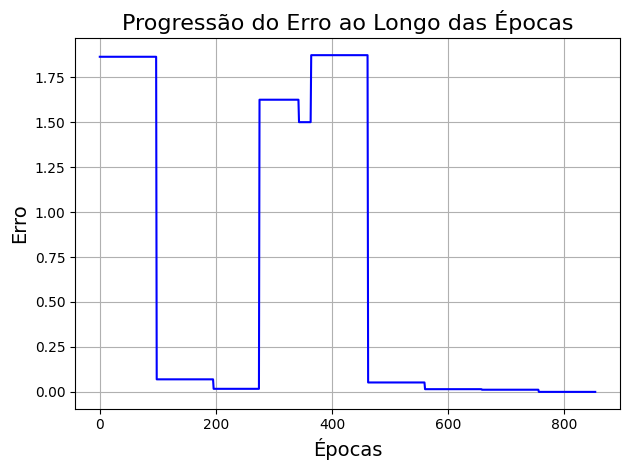

In [28]:
# Plotando o gráfico para visualizar a progressão da perda

plt.plot(historico_loss, color='blue', linestyle='-')
plt.title('Progressão do Erro ao Longo das Épocas', fontsize=16)
plt.xlabel('Épocas', fontsize=14)
plt.ylabel('Erro', fontsize=14)
plt.grid(True)  # Adicionando linhas de grade para melhorar a legibilidade
plt.tight_layout()  # Ajustando o layout para evitar sobreposição de elementos
plt.show()

In [29]:
# Salvando o modelo já treinado

modelo.to_disk("modelo_twitter")

# Avaliação do modelo

In [30]:
# Carregando modelo que foi salvo o driven

modelo_twitter = spacy.load("/content/drive/MyDrive/classificadores treinados/modelo_twitter")
modelo_twitter

In [31]:
# Fazendo previsões dos textos

previsoes = []
for texto in base_teste['tweet_text']:
  previsao = modelo_twitter(texto)
  previsoes.append(previsao.cats)

In [32]:
# Pegando as previsoes e obtendo o resultado real, tirando da forma de dicionário e retornando apenas a previsão

previsoes_final = []
for previsao in previsoes:
  if previsao['POSITIVO'] > previsao['NEGATIVO']: # se o valor na pos['POSITIVO'] for maior que ['NEGATIVO'] vai ser add alegria
    previsoes_final.append(1)
  else: # senão vai ser adicionado 0
    previsoes_final.append(0)

previsoes_final = np.array(previsoes_final)

In [33]:
# Obtendo todas as respostas reais

respostas_reais = base_teste['sentiment'].values
respostas_reais

array([1, 1, 1, ..., 0, 0, 0])

In [34]:
# Accuracy score

print(f'A taxa de acerto foi de: {accuracy_score(respostas_reais, previsoes_final)}')

A taxa de acerto foi de: 0.9974


In [35]:
# Relatório de classificação

print(f'Relatório de classificação: \n{classification_report(respostas_reais, previsoes_final)}')

Relatório de classificação: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2500
           1       1.00      1.00      1.00      2500

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



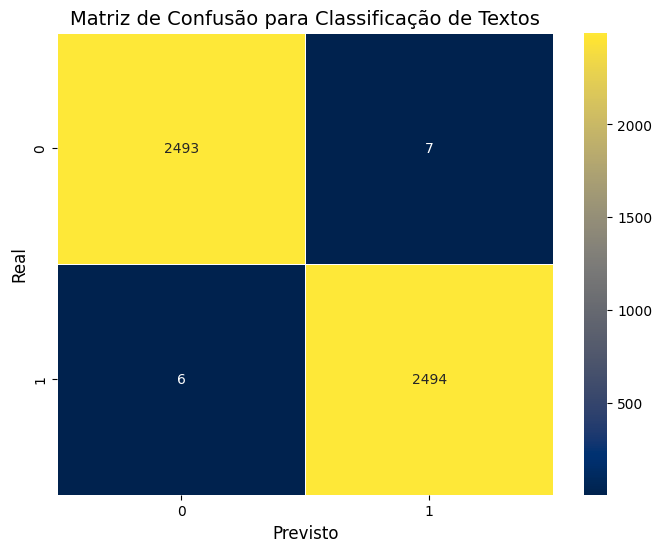

In [36]:
# Gerando a matriz de confusão
cm = confusion_matrix(respostas_reais, previsoes_final)

# Plotando a figura
plt.figure(figsize=(8, 6))  # Ajustando o tamanho da figura para uma melhor visualização
sns.heatmap(cm, annot=True, fmt='d', cmap='cividis', linewidths=.5)  # Adicionando anotações e estilo
plt.xlabel('Previsto', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.title('Matriz de Confusão para Classificação de Textos', fontsize=14)
plt.xticks(fontsize=10)  # Ajustando o tamanho das marcações no eixo x
plt.yticks(fontsize=10)  # Ajustando o tamanho das marcações no eixo y
plt.show()